# CaMKII system simplification and sensitivity analysis

In [1]:
using ModelingToolkit
using OrdinaryDiffEq, SteadyStateDiffEq, DiffEqCallbacks
using Plots
using LsqFit
using CaMKIIModel
using CaMKIIModel: μM, hil, second, Hz
Plots.default(lw=1.5)

## CaMKII sensitivity to calcium

Modeling CaM-Cax binding to CaMKII only. No phosphorylation or oxidation reactions.

In [2]:
@parameters Ca = 0μM ROS = 0μM
sys = get_camkii_sys(; Ca, ROS, simplify=true)

Model camkii_sys:
Equations (17):
  17 standard: see equations(camkii_sys)
Unknowns (17): see unknowns(camkii_sys)
  CaMKOX(t) [defaults to 0]
  CaMKPOX(t) [defaults to 0]
  CaMKP2(t) [defaults to 0.83143]
  CaMKP(t) [defaults to 3.3]
  ⋮
Parameters (40): see parameters(camkii_sys)
  k_2N_on [defaults to 0.2]
  k_1N_on [defaults to 0.1]
  kCaM0_on [defaults to 3.8e-6]
  k_P2_P1 [defaults to 6.66667e-5]
  ⋮
Observed (3): see observed(camkii_sys)

In [3]:
prob = SteadyStateProblem(sys, [sys.k_phosCaM => 0])

SteadyStateProblem with uType Vector{Float64}. In-place: true
u0: 17-element Vector{Float64}:
 0.0
 0.0
 0.83143
 3.3
 0.0
 0.0
 0.01581
 0.010750000000000001
 1.01
 0.62372
 0.00666
 0.0166
 0.39868000000000003
 1.0
 2.0e-5
 0.008577999999999999
 0.08433

Physiological cytosolic calcium concentrations ranges from 30nM to 10μM.

In [4]:
ca = logrange(0.03μM, 10μM, 1001)
prob_func = (prob, i, repeat) -> begin
    remake(prob, p=[Ca => ca[i]])
end
trajectories = length(ca)
alg = DynamicSS(FBDF())
sol0 = solve(prob, alg; abstol=1e-10, reltol=1e-10) ## warmup
@time sim = solve(EnsembleProblem(prob; prob_func, safetycopy=false), alg; trajectories, abstol=1e-10, reltol=1e-10)

  3.240866 seconds (201.09 M allocations: 6.827 GiB, 26.14% gc time, 1090.32% compilation time: 1% of which was recompilation)


EnsembleSolution Solution of length 1001 with uType:
SciMLBase.NonlinearSolution{Float64, 1, Vector{Float64}, Vector{Float64}, SteadyStateProblem{Vector{Float64}, true, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 3, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x63da2329, 0xafe83799, 0xf2fc8a42, 0x110ec7ef, 0x5c3fa89c), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf290c0de, 0x6ed5f46a, 0x5900643f, 0x38f01bf6, 0x54fa31bb), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionC

In [5]:
"""Extract values from ensemble simulations by a symbol"""
extract(sim, k) = map(s -> s[k], sim)
"""Calculate Root Mean Square Error (RMSE)"""
rmse(fit) = sqrt(sum(abs2, fit.resid) / length(fit.resid))

rmse

Status of the CaMKII system across a range of calcium concentrations.

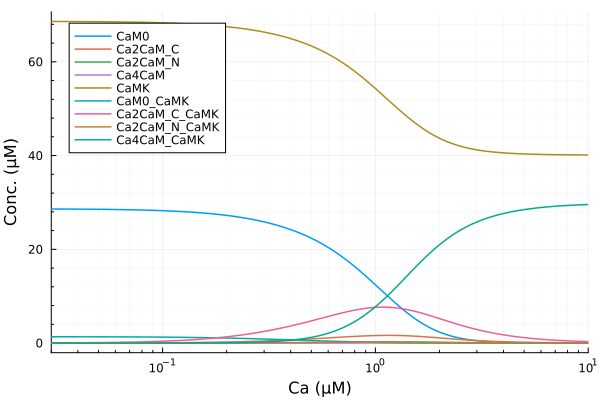

In [6]:
xopts = (xlabel="Ca (μM)", xscale=:log10, minorgrid=true, xlims=(ca[1], ca[end]))
plot(ca, extract(sim, sys.CaM0), lab="CaM0", ylabel="Conc. (μM)"; xopts...)
plot!(ca, extract(sim, sys.Ca2CaM_C), lab="Ca2CaM_C")
plot!(ca, extract(sim, sys.Ca2CaM_N), lab="Ca2CaM_N")
plot!(ca, extract(sim, sys.Ca4CaM), lab="Ca4CaM")
plot!(ca, extract(sim, sys.CaMK), lab="CaMK")
plot!(ca, extract(sim, sys.CaM0_CaMK), lab="CaM0_CaMK")
plot!(ca, extract(sim, sys.Ca2CaM_C_CaMK), lab="Ca2CaM_C_CaMK")
plot!(ca, extract(sim, sys.Ca2CaM_N_CaMK), lab="Ca2CaM_N_CaMK")
plot!(ca, extract(sim, sys.Ca4CaM_CaMK), lab="Ca4CaM_CaMK", legend=:topleft)

In [7]:
savefig("camkii_cam_binding.png")
savefig("camkii_cam_binding.pdf")

"/home/sosiristseng/camkii-cardiomyocyte-model/docs/camkii_cam_binding.pdf"

Active CaMKII is defined as CaMKII bound to CaM except CaM0 (apo CaM)

Basal activity with 30nM Ca is 4.840651768311943e-8


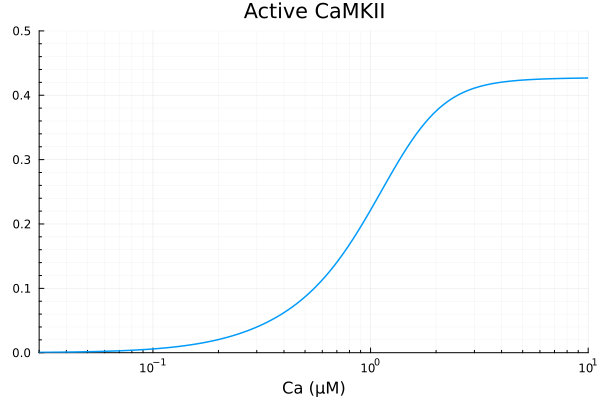

In [8]:
CaMKAct = 1 - (sys.CaMK + sys.CaM0_CaMK) / sys.CAMKII_T
println("Basal activity with 30nM Ca is ", sol0[CaMKAct][end])
xdata = ca
ydata = extract(sim, CaMKAct)
plot(xdata, ydata, label=false, title="Active CaMKII", ylims=(0, 0.5); xopts...)

In [9]:
savefig("camkii_act.png")
savefig("camkii_act.pdf")

"/home/sosiristseng/camkii-cardiomyocyte-model/docs/camkii_act.pdf"

## Least-square fitting

Least-square fitting of steady state CaMKII activities against calcium concentrations.

### Old model

Using a single Hill function to fit steady state CaMKII activities.

$$
\text{CaMKII}_{act} = p_1 \frac{c^n}{c^n + p_2^n}+ p_3
$$

In [ ]:
@. model_camk_single_hill(x, p) = p[1] * hil(x, p[2], p[4]) + p[3]
p0 = [0.4, 1μM, 0.0, 2.0]
lb = [0.0, 0.001μM, 0.0, 1.0]
@time fit = curve_fit(model_camk_single_hill, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

In [ ]:
println("Basal activity: ", pestim[3])
println("Maximal activated activity: ", pestim[1])
println("Half-saturation Ca concentration: ", pestim[2], " μM")
println("Hill coefficient: ", pestim[4])
println("RMSE: ", rmse(fit))

Fit result and the original model

In [ ]:
yestim = model_camk_single_hill.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata yestim], lab=["Full model" "Fitted"], line=[:dash :dot], title="Single Hill function fit", legend=:topleft, ylabel="Bound CaMKII"; xopts...)

### New model

Using two Hill functions to fit steady state CaMKII activities.

$$
\text{CaMKII}_{act} = p_1 \frac{c^2}{c^2 + p_2^2} + p_3 \frac{c^4}{c^4 + p_4^4} + p_5
$$

In [13]:
@. model_camk(x, p) = p[1] * hil(x, p[2], 2) + p[3] * hil(x, p[4], 4) + p[5]
p0 = [0.4, 1μM, 0.0, 1μM, 0.0]
lb = [0.0, 0.001μM, 0.0, 0.001μM, 0.0]
@time fit = curve_fit(model_camk, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

  0.159628 seconds (637.02 k allocations: 31.699 MiB, 98.79% compilation time: 100% of which was recompilation)


5-element Vector{Float64}:
 0.26501200198618763
 0.7383958712607854
 0.16357502563719153
 1.251273659020671
 0.001015012724068577

In [14]:
println("Basal activity: ", pestim[5])
println("Maximal activity by 2 Ca binding): ", pestim[1])
println("Half saturation concentration for 2 Ca binding: ", pestim[2], " μM")
println("Maximal activity by 4 Ca binding): ", pestim[3])
println("Half saturation concentration for 4 Ca binding: ", pestim[4], " μM")
println("RMSE: ", rmse(fit))

Basal activity: 0.001015012724068577
Maximal activity by 2 Ca binding): 0.26501200198618763
Half saturation concentration for 2 Ca binding: 0.7383958712607854 μM
Maximal activity by 4 Ca binding): 0.16357502563719153
Half saturation concentration for 4 Ca binding: 1.251273659020671 μM
RMSE: 0.0009687123633282261


Visualize fitting

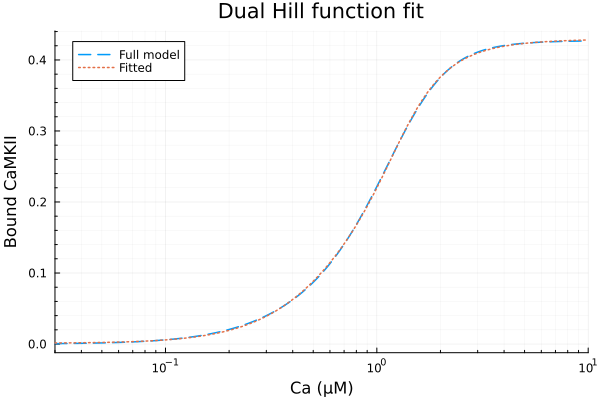

In [12]:
yestim = model_camk.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata yestim], lab=["Full model" "Fitted"], line=[:dash :dot], title="Dual Hill function fit", legend=:topleft, ylabel="Bound CaMKII"; xopts...)

In [15]:
savefig("camkii_act_fit.png")
savefig("camkii_act_fit.pdf")

"/home/sosiristseng/camkii-cardiomyocyte-model/docs/camkii_act_fit.pdf"

## Runtime information

In [ ]:
using InteractiveUtils
InteractiveUtils.versioninfo()

In [ ]:
using Pkg
Pkg.status()